## 0. 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns


## 1. 데이터 불러오기

In [2]:
bike = pd.read_csv('bike.csv')
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## 2. 데이터 분석

### EDA / 시각화 해보기

#### 최종 결과
- season : 2~3분기때 수요가 많고 1분기때 수요가 적음 (month와 연관 있어보임)
- holiday / workingday : 수요량만 봤을때는 의미없는 데이터로 보이지만 시간대별 추세를 보게되면 일하는 날은 출퇴근때 쉬는날은 오후시간대 많음
- weather : 맑은날 흐린날 수요가 많고 가벼운 눈/비때 수요가 낮음
- temp (atemp) : 양의 상관관계 가짐 (온도가 높을 수록 수요 증가)
- humidity : 음의 상관관계 가짐 (습도가 높을 수록 수요 감소)
- month : 월별 수요 변화량
- hour : 시간대별 수요량 변화 (출퇴근 시간에 많다)
- count : 수요량 (y값 )

In [3]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# datetime 년 월 일 시 새로운 컬럼으로 만들기
# object를 datetime 형태로 변경해서 나누기
bike["datetime"] = bike.datetime.apply(pd.to_datetime)


In [5]:
bike['year'] = bike.datetime.apply(lambda x : x.year)
bike['month'] = bike.datetime.apply(lambda x : x.month)
bike['day'] = bike.datetime.apply(lambda x : x.day)
bike['hour'] = bike.datetime.apply(lambda x : x.hour)
bike

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


In [6]:
# 필요 없는 컬럼 삭제
bike = bike.drop(["datetime", "casual", "registered"], axis = 1)
bike

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


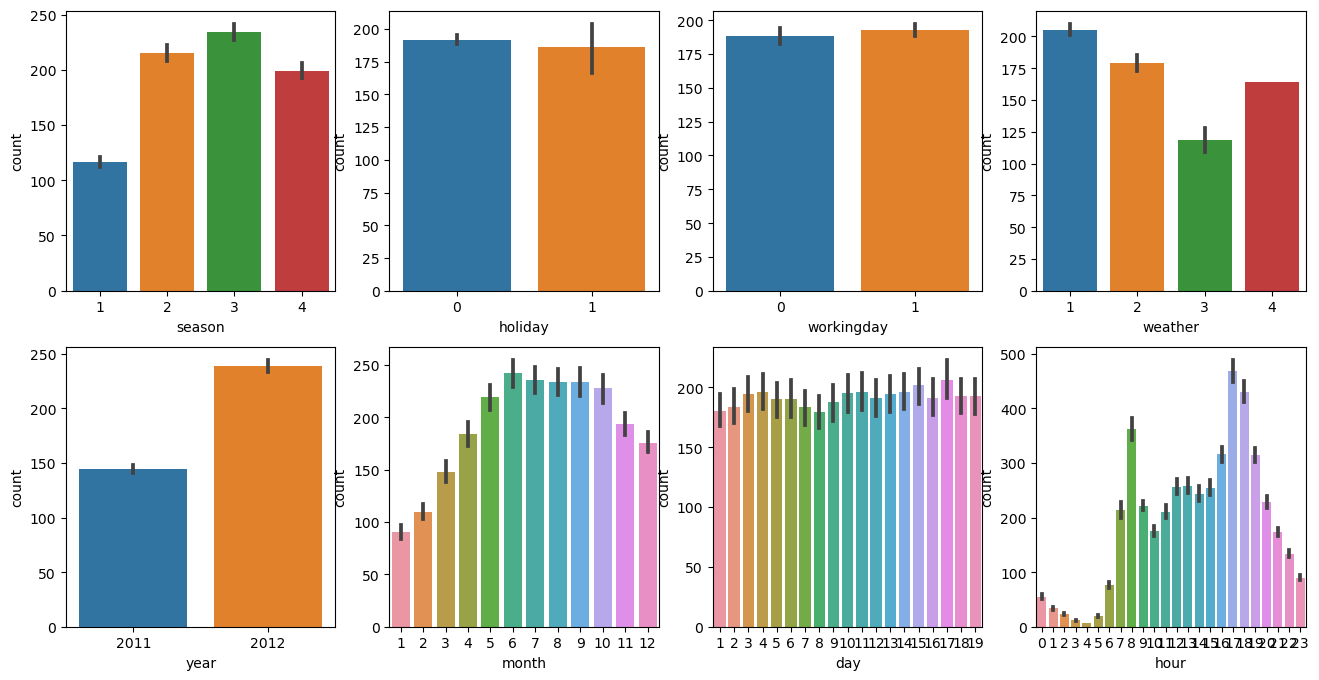

In [7]:
# y = count
# x 중 시각화 기법 선택을 위해 범주형, 수치형 데이터 구분
# 범주형(막대) : ['season', 'holiday', 'workingday', 'weather', 'year', 'month','day','hour']
# 수치형(산점도+ 회귀선) : ["temp", "atemp", "humidity", "windspeed"]

fig, ax = plt.subplots(2,4, figsize = (16,8))
category = ['season', 'holiday', 'workingday', 'weather', 'year', 'month','day','hour']
for i in range(0, len(category)):
    r = i//4
    c = i%4
    sns.barplot(data = bike, x = category[i], y = 'count', ax = ax[r][c])


## season : 1분기떄 수요가 낮고 2~3분기때 수요가 높다
## holiday/ workingday : count에 크게 영향을 주지 않아 보인다. 하지만 다은 feature와의 상관관계가 있을 수 있다.
## weather : 가벼운 눈/비일때 수요가 가장 낮음 / 맑거나 흐릴때 수요가 높다
## 2011보다 2012에 더 수요가 높다?
## 1~2 (겨울)에 적고 6~10월(봄~여름) 이용자가 많다. 시즌과 관계가 많아 보인다.
## day는 큰 영향이 없어보인다.
## 8시, 17~18시에 수요가 가장 높다. (출퇴근 시간)


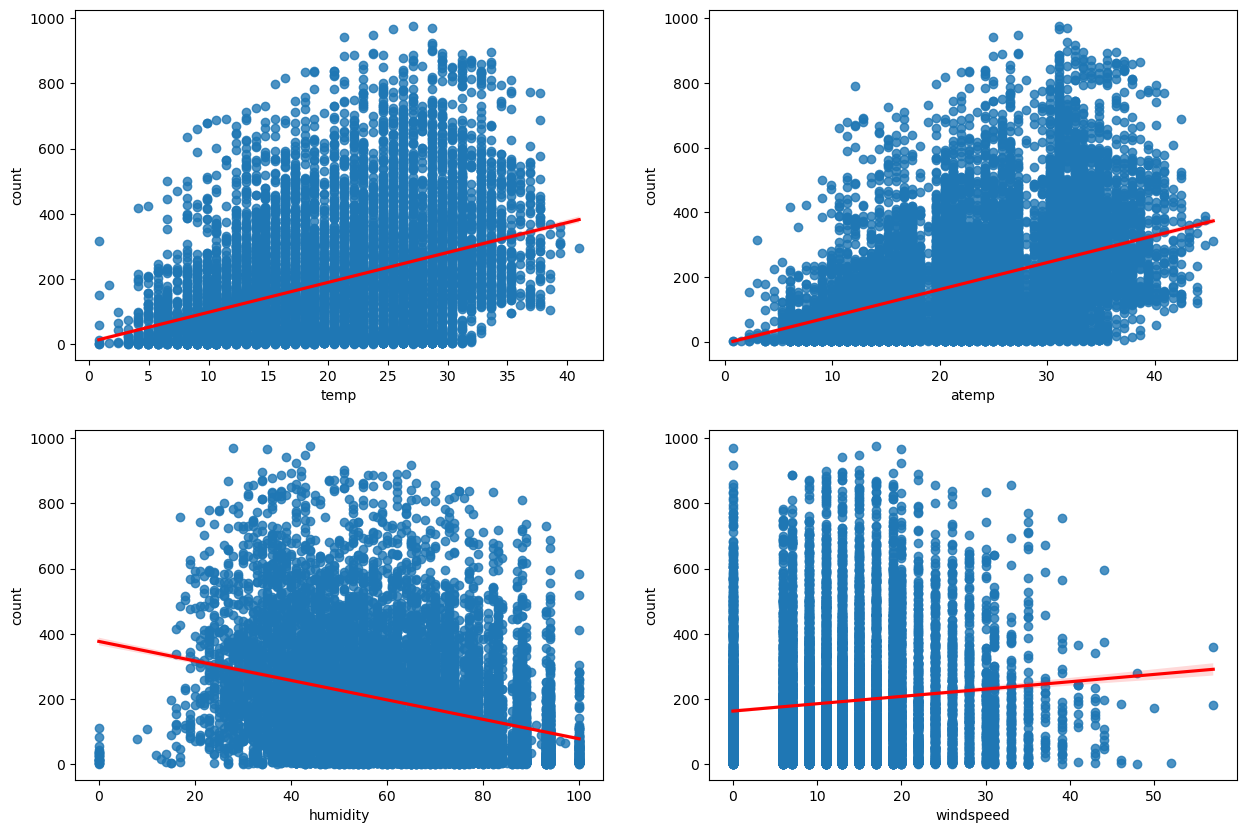

In [8]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
numerical = ["temp", "atemp", "humidity", "windspeed"]

for i in range(0,len(numerical)):
    r = i//2
    c = i%2
    sns.regplot(data = bike, x = numerical[i], y = 'count', ax = ax[r][c],line_kws={'color':'red'})

## 온도가 높을 수록(양의 상관관계), 습도는 낮을수록(음의 상관관계) 수요가 증가함
## 풍속은 크게 상관이 있는 것 같지 않다.

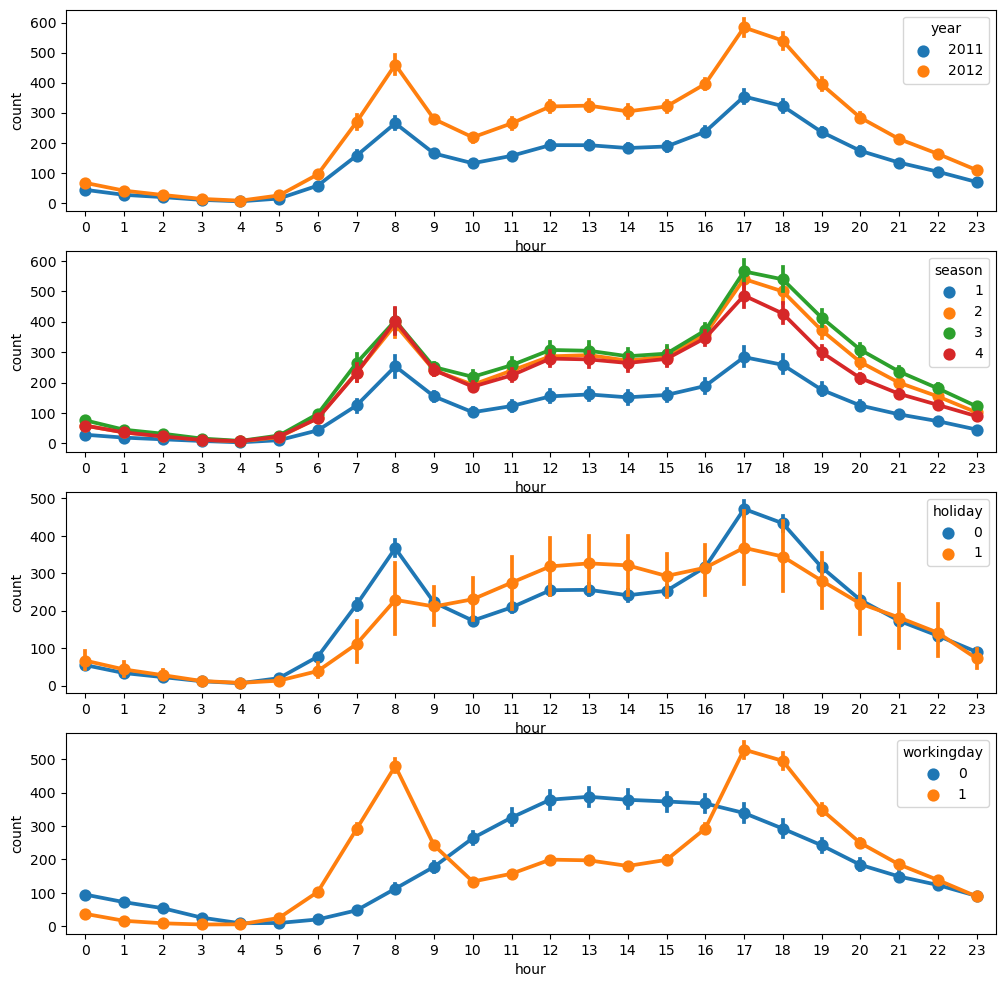

In [9]:
# 꺽은선 그래프
# 수치형 데이터중 시간/날짜 => 시계열그래프
# 시간의 흐름에 따라 데이터가 변화하는 추세를 볼 필요 있따.


time_feature = ['year', 'season', 'holiday', 'workingday']
fig, ax = plt.subplots(4, figsize = (12,12))

for i, f in enumerate(time_feature):
    sns.pointplot(data = bike, x = 'hour', y = 'count', hue = f , ax = ax[i])


# 년도별 / 분기별로 수요의 차이가 있지만 그 모양(추세가) 시간대 별로 비슷함.  
# 0일때(일할때)는 8 / 17 (출퇴근시간)에 높지만 1일때(쉴때)는 그렇지 않다
# 1일떄(일할때)는 출퇴근 시간에 높고 0일떄(쉴떄)는 오후시간때 수요가 많다.

# 막대로 볼때는 holiday와 workingday가 count에 영향을 주지 않는것 같았지만 
# hour와 함께보니 시간대 별 수요량의 차이에 의미있는 영향을 주는것을 확인 할 수 잇따.


<Axes: >

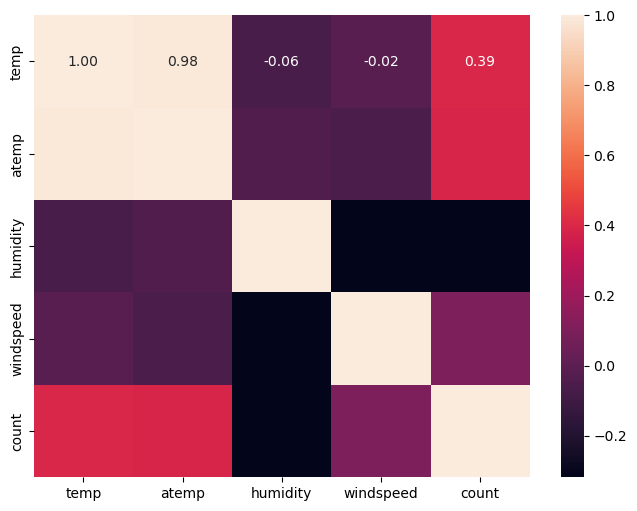

In [10]:
# 히트맵 (수치형 데이터)

corr_feature = ["temp", "atemp", "humidity", "windspeed", "count"]
fig = plt.subplots(figsize=(8,6))

sns.heatmap(bike[corr_feature].corr(), annot=True, fmt=".2f")

# temp , atemp 둘의 상관관계가 거의 1 => 둘중 하나만 상요
# windspeed 0.1로 상관관계가 매우 낮음
# temp는 양의 상관관계 / humidity 는 음의 상관관계를 보인다.


## 3. 데이터 전처리

### 인코딩, 스케일링
1. y값 로그변환 (스케일링)
2. 범주형 데이터 원핫인코딩( 숫서에 의미가 없을때 숫자의 의미를 없애기 위해 )

In [11]:
bike_result = bike[ ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'month', 'hour' , 'count'] ]

In [12]:
# 스케일링 함수
def scaler(data, method = 'None'):
    if method == 'standard':
        sacled_data = StandardScaler().fit_transform(data)
    elif method == 'minmax':
        sacled_data = MinMaxScaler().fit_transform(data)
    elif method == 'log':
        sacled_data = np.log1p(data)
    else:
        sacled_data = data
    return sacled_data

<Axes: >

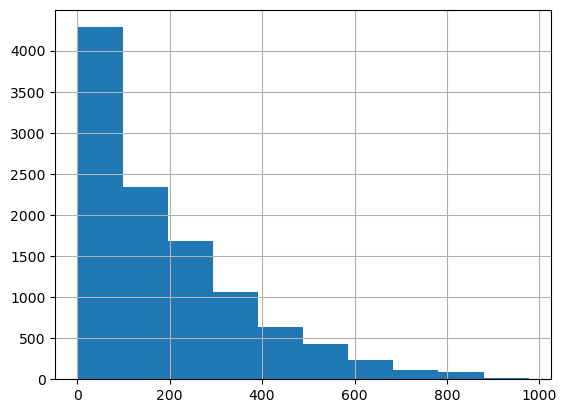

In [14]:
# 이대로 학습하면 RMSE가 높다
# 회귀에서 오차값이 높을 경우 y가 정규분포를 이루고 있는지 확인한다.
# 왼쪽으로 치우져진 그래프 => 로그, 제곱근, 역수
# 오른쪽으로 치우쳐진 그래프 => 지수, 제곱

# 왼쪽으로 치우친 형태
bike_result["count"].hist()


C:\Users\ssh\AppData\Local\Temp\ipykernel_10540\4176035312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_result["count"] = np.log1p(bike_result["count"])


<Axes: >

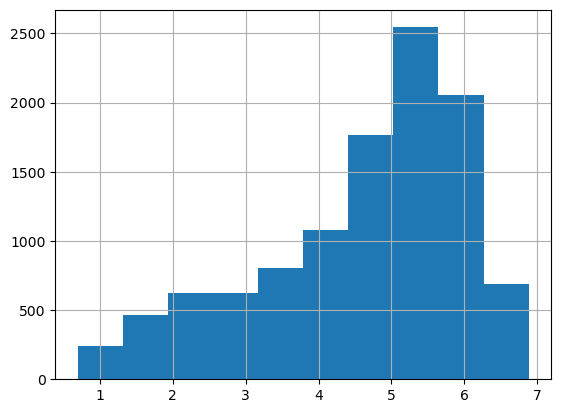

In [15]:
# log를 해주면 약간 정규분포를 따르는 형태로 변환해줌
# 로그 함수 numpy.log1p()로 변환 된 값을 원래 값으로 변환 : np.expm1()

bike_result["count"] = np.log1p(bike_result["count"])
bike_result["count"].hist()

In [16]:
x = bike_result.loc[ : , :'hour']
y = bike_result['count']

In [17]:
# 데이터 인코딩
x_one_hot = pd.get_dummies(x, columns = ['season','holiday','workingday','weather','month','hour'])

In [18]:
x_one_hot.columns

Index(['temp', 'humidity', 'season_1', 'season_2', 'season_3', 'season_4',
       'holiday_0', 'holiday_1', 'workingday_0', 'workingday_1', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')

In [19]:
# 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(x_one_hot, y, test_size=0.3, random_state=42)

## 4. 모델 생성, 평가

In [13]:
# 평가 점수 함수
from sklearn.metrics import r2_score, mean_squared_error

def get_score(model):
    model.fit(x_train, y_train)
    pre = model.predict(x_test)
    
    pre = np.expm1(pre)
    y = np.expm1(y_test)
    
    mse = mean_squared_error(pre, y)
    r2 = r2_score(pre, y)
    rmse = np.sqrt(mse)
    print("rmse : ", rmse)
    print("r2 : ", r2)
    return rmse, r2

In [22]:
# 모델 만들기
linear_model = LinearRegression()
linear_rmse, linear_r2 = get_score(linear_model)

rmse :  110.77905918947943
r2 :  0.3591268685103257


In [23]:
setattr(pd, "Int64Index", pd.Index)

In [24]:
linear = LinearRegression()
ridge = Ridge(alpha = 0.61)
lasso = Lasso(alpha = 0.0003)
dtr = DecisionTreeRegressor(max_depth = 14, min_samples_split = 20)
xgb = XGBRegressor(n_estimators = 100)


models = [linear, ridge, lasso, dtr, xgb]
model_names = ["LinearRegression","Ridge","Lasso", "DecisionTreeRegressor", "XGBRegressor"]

for name, model in zip(model_names, models):
    print("=====", name, "=====")
    get_score(model)

===== LinearRegression =====
rmse :  110.77905918947943
r2 :  0.3591268685103257
===== Ridge =====
rmse :  110.8391932014042
r2 :  0.35641788454685375
===== Lasso =====
rmse :  111.02630534131131
r2 :  0.3474094293587031
===== DecisionTreeRegressor =====
rmse :  106.37463813006612
r2 :  0.4225669694108444
===== XGBRegressor =====
rmse :  72.05143704695344
r2 :  0.8044853399274648


In [25]:
from hyperopt import hp
from hyperopt import STATUS_OK

xgb_search = {"max_depth" : hp.quniform("max_depth", 5, 20, 1),
             "learning_rate" : hp.uniform("learning_rate", 0.01, 0.2),
             "n_estimators" : hp.quniform("n_estimators", 50, 500, 1),
             "min_child_weight" : hp.quniform("min_child_weight",2,20,1)}

def objective_func(search_space):
    xgb_model = XGBRegressor(n_estimators = int(search_space["n_estimators"]),
                             learning_rate = search_space["learning_rate"],
                             max_depth = int(search_space["max_depth"]), 
                              min_child_weight = int(search_space["min_child_weight"]),
                              subsample = 0.6,
                              eval_metric = "rmse")
    # 교차 검증
    score = cross_val_score(XGBRegressor(), x_train, y_train, scoring = "r2", cv = 5)

    return {"loss" : -1 * np.mean(score), "status" : STATUS_OK}

In [26]:
from hyperopt import fmin, tpe, Trials

import warnings
warnings.filterwarnings("ignore")

trial_val = Trials()

best = fmin(fn = objective_func,
           space = xgb_search,
           max_evals=150,
           trials = trial_val, rstate = np.random.default_rng(seed = 9), verbose=2)

print("best : ", best)


TPE is being used as the default algorithm.


100%|██████████| 150/150 [01:11<00:00,  2.11trial/s, best loss: -0.9154881599426232]
best :  {'learning_rate': 0.04238919125135764, 'max_depth': 7.0, 'min_child_weight': 19.0, 'n_estimators': 312.0}


In [27]:
xgb_best = XGBRegressor(n_estimators = 312, learning_rate = 0.042, max_depth = 7, min_child_weight = 19, subsample = 0.6, eval_metic='rmse')

In [28]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
evals = [ (x_tr, y_tr), (x_val, y_val) ]

In [30]:
xgb_best.fit(x_tr, y_tr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metic='rmse', eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.042, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=19, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=312, n_jobs=None, ...)

In [31]:
pre = xgb_best.predict(x_test)
pre = np.expm1(pre)
y_test = np.expm1(y_test)
    
mse = mean_squared_error(pre, y_test)
r2 = r2_score(pre, y_test)
rmse = np.sqrt(mse)
print("rmse : ", rmse)
print("r2 : ", r2)

rmse :  73.28159712068489
r2 :  0.7687607599225046
